In [1]:
import numpy as np
import six
import os
import skimage.io as skio
import skimage.transform as skit

import pulse2percept as p2p
import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-02 12:24:39,170 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [3]:
px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [4]:
argus = p2p.implants.ArgusII()

In [5]:
x_range = (-30, 30)
y_range = (-20, 20)
out_shape = (768, 1024)

In [6]:
pts_in = []
pts_dva = []
pts_out = []
for xy, e in zip(px_argus2, argus):
    pts_in.append(xy)
    
    dva = p2p.retina.ret2dva([e.x_center, e.y_center])
    pts_dva.append(dva)
    
    xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
    yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
    pts_out.append([xout, yout])

In [7]:
argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))

In [8]:
def get_avg_image(X, subject, electrode, amp, align_center):
    idx = np.logical_and(X['subject'] == subject, X['electrode'] == electrode)
    idx = np.logical_and(idx, X['amp'] == amp)

    avg_img = None
    for _, row in X[idx].iterrows():
        img = skio.imread(os.path.join(row['folder'], row['filename']), as_grey=True)
        transl = [align_center[0] - row['centroid'][1],
                  align_center[1] - row['centroid'][0]]
        trafo = skit.EuclideanTransform(translation=transl)
        if avg_img is None:
            avg_img = skit.warp(img, trafo.inverse)
        else:
            avg_img += skit.warp(img, trafo.inverse)
    return avg_img

In [9]:
subject = '51-009'
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape', subject)
X, y = p2pspatial.load_data(rootfolder, subject=subject)
electrodes = np.unique(X.groupby(['electrode', 'amp']).electrode.all())
amps = np.unique(X['amp'])

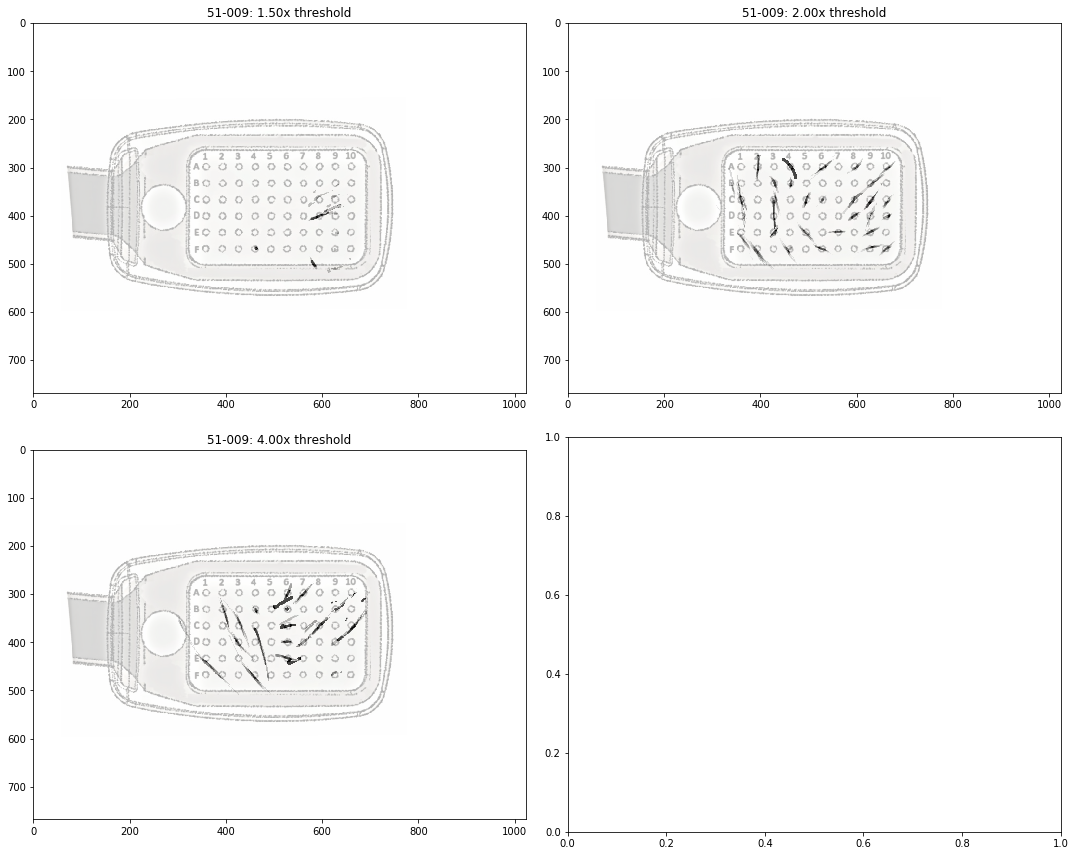

In [10]:
nc = 2
nr = int(np.ceil(len(amps) / 2))

fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(15, 6 * nr))
fig.tight_layout()

for amp, ax in zip(amps, axes.ravel()):
    ax.set_facecolor('white')
    for el in electrodes:
        ename = '%s%d' % (el[0], int(el[1:]))
        e_pos = p2p.retina.ret2dva((argus[ename].x_center, argus[ename].y_center))
        align_center = dva2out(e_pos)[0]
        avg = get_avg_image(X, subject, el, amp, align_center)
        if avg is None:
            continue
        avg /= avg.max()
        ax.imshow(1 - np.ma.masked_where(avg < 0.5, avg), cmap='gray')
#         ax.plot(*align_center, 'o')
        ax.set_title('%s: %.2fx threshold' % (subject, amp))
    ax.imshow(skit.warp(img_argus2, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
fig.savefig('shape-%s.png' % subject)